Distribution of MI scores of entries in several thesauri. Do thesauri just happen to contain better features?

In [71]:
%cd ~/NetBeansProjects/thesisgenerator/
from collections import Counter, defaultdict
from thesisgenerator.utils.conf_file_utils import parse_config_file
from thesisgenerator.utils.data_utils import get_tokenized_data, get_tokenizer_settings_from_conf
from thesisgenerator.plugins.bov import ThesaurusVectorizer
from discoutils.thesaurus_loader import Vectors
from sklearn.feature_selection import f_classif, chi2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from thesisgenerator.utils.misc import calculate_log_odds
from scipy.sparse import csr_matrix
%matplotlib inline

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/thesisgenerator


In [22]:
conf, configspec_file = parse_config_file('conf/exp1/exp1_base.conf')
tr_data = conf['training_data'] + '.gz'
xtr, ytr, _, _ = get_tokenized_data(tr_data,
                                        get_tokenizer_settings_from_conf(conf))

X, vocab = ThesaurusVectorizer(min_df=0).fit_transform(xtr)
vocab = {str(k): v for k,v in vocab.items()}
phrases = [str(s) for s in vocab.keys()]

In [3]:
fvalues, pvalues = f_classif(X, ytr)

In [4]:
scores = {}
paths = ['../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Baroni.events.filtered.strings',
        '../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Add.events.filtered.strings',
        '../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Left.events.filtered.strings',
        '../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Right.events.filtered.strings']
for path in paths:
    v = Vectors.from_tsv(path)
    scores_this_composer = []
    for i, (df, idx) in enumerate(vocab.items()):
        if df in v:
            scores_this_composer.append(fvalues[idx])
    scores[path] = scores_this_composer
    del v

OSError: File does not exist: /Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Left.events.filtered.strings

In [ ]:
f, axes = plt.subplots(2, 2, sharey=True, sharex=True)
names, colors = 'BALR', 'rgbc'
for i, (_, vals) in enumerate(scores.items()):
    axes.flat[i].hist(vals, bins=20, alpha=.3, color=colors[i]);
    axes.flat[i].set_title(names[i])
plt.savefig('midist.pdf', format='pdf')

In [ ]:
X1 = [
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [0, 1, 1, 1],
        [0, 0, 1, 1],
    ]
y1 = np.array([0, 0, 1, 1])
f_classif(X1, y1)

In [ ]:
calculate_log_odds(csr_matrix(X1), y1)

# what happens to good classifier features when redirected through a thesaurus

shape is (2000, 47370)


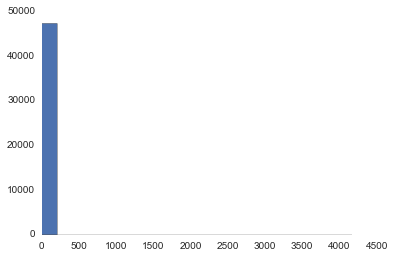

In [5]:
# are very informative features (ones strongly associated with class C)
# replaced by other informative feats or not?
print('shape is', X.shape)
a, b = chi2(X, ytr) # small values of A mean informative features
plt.hist(a, bins=20);

In [6]:
X.shape

(2000, 47370)

In [7]:
ytr[ytr != 'Automotive'] = 'NotAutomotive' # lo_score assumes two classes, let's make it that was
# pre-select features using chi2 (much faster, but selects both positive and negative features)
premask, _ = f_classif(X, ytr)
# %time lo_automotive = calculate_log_odds(X, ytr, column_indices=np.argsort(premask)[:1000])
# %time lo_automotive = calculate_log_odds(X, ytr, column_indices=set(np.random.randint(0,X.shape[1],20000)))
%time lo_automotive = calculate_log_odds(X, ytr)

CPU times: user 38.5 s, sys: 93.2 ms, total: 38.6 s
Wall time: 39 s


18.09217669226155

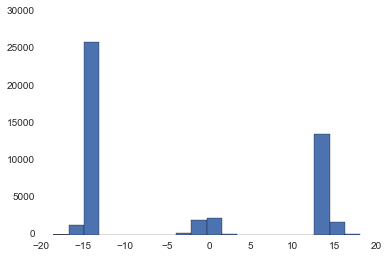

In [8]:
plt.hist(lo_automotive, bins=20);
max(lo_automotive)

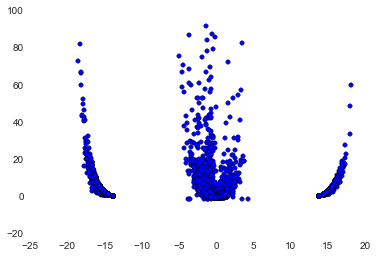

In [9]:
premask[premask>100] = -1
plt.scatter(lo_automotive, premask);
# looks like there are both good and bad features (according to chi2) in terms of LO score

In [10]:
# import pandas as pd
# density_df = pd.DataFrame({'X':lo_automotive[:100], 'Y':premask[:100]})
# sns.kdeplot(lo_automotive[:100], premask[:100])
# data = np.vstack([lo_automotive[:100], premask[:100]])
# sns.kdeplot(density_df.ix[:11], shade=True);
# data.shape
# density_df

In [55]:
orig_lo_automotive = lo_automotive.copy()
lo_automotive[np.asarray(X.sum(axis=0)).ravel() < 5] = 0 # de-select infreq features
# lets look at the informative features
inv_vocab = {v:k for k,v in vocab.items()}
good_feats_idx = np.where((lo_automotive>10)|(lo_automotive<-10))[0] # index of 100 most informative features (either for or against automotive)
good_feats = set(str(inv_vocab[idx]) for idx in good_feats_idx)
good_feats, len(good_feats)

({'small/J_bird/N',
  'great/N_leash/N',
  'jerry/N',
  'catgenie/N',
  'rash/N',
  'exo/N',
  'silencer/N',
  'granule/N',
  'artificial/J',
  'melted/J_snow/N',
  'weakest/J_link/N',
  'neem/N',
  'ferret/N',
  'white/J_fur/N',
  'use/V_conditioner/N',
  'chemical/N_smell/N',
  'fun/N_toy/N',
  'foster/J',
  'multimeter/N',
  'herpes/N',
  'blazer/N',
  'cookout/N',
  'fogging/N',
  'favorite/J_toy/N',
  'lab/N',
  'cooking/N',
  'air/N_tool/N',
  'service/N_center/N',
  'tear/V_stain/N',
  'giraffe/N',
  'salt/N_water/N',
  'interwoven/J',
  'cloudy/J',
  'fit/V_dog/N',
  'melted/J',
  'strong/J_chewer/N',
  'warn/N',
  'kitten/N_collar/N',
  'iii/N',
  'chicken/N_flavor/N',
  'chewer/N',
  'society/N',
  'dog/N_smell/N',
  'guinea/N',
  'prep/N',
  'westie/N',
  'hound/N',
  'healthy/J_treat/N',
  'terra/N',
  'black/J_walmart/N',
  'great/J_dog/N',
  'entertaining/J',
  'panic/N_mouse/N',
  'client/N',
  'sidewalk/N',
  'raccoon/N',
  'bacterial/J',
  'fox/N',
  'canine/N',
  'amp

In [12]:
v1 = Vectors.from_tsv('../FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-gigaw_100percent-rep0_Add.events.filtered.strings', allow_lexical_overlap=False)
# v3 = Vectors.from_tsv('../FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_15percent-rep0_Add.events.filtered.strings', allow_lexical_overlap=False)
v3 = Vectors.from_tsv('../FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_50percent-rep0_Add.events.filtered.strings', allow_lexical_overlap=False)
v4 = Vectors.from_tsv('../FeatureExtractionToolkit/glove/AN_NN_glove-wiki_Add.events.filtered.strings', allow_lexical_overlap=False)
# v5 = Vectors.from_tsv('../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Baroni.events.filtered.strings', allow_lexical_overlap=False)
# v6 = Vectors.from_tsv('../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Add.events.filtered.strings', allow_lexical_overlap=False)

In [60]:
def evaluate(v):
    v.init_sims(vocab=phrases, n_neighbors=5) # 1000
    
    # test 1- set overlap of good neighbours
    lengths = []
    for feat in good_feats:
        neigh = v.get_nearest_neighbours(feat)
        if neigh:
            neigh = set(x[0] for x in neigh)
            inters = neigh.intersection(good_feats)
            lengths.append(len(inters))
    #         print(feat, 'inters', inters)
    #     else:
    #         print('no neigh for', feat)
    print('mean overlap', np.mean(lengths))
    
    # test 2- how many good feats get messed up
    data = []
    for feat in good_feats:
        neigh = v.get_nearest_neighbours(feat)
        if neigh:
            neigh = set(x[0] for x in neigh[:3])
            data.append([lo_automotive[vocab[feat]]] + [orig_lo_automotive[vocab[n]] for n in neigh])
    df = pd.DataFrame(data, columns=['orig', 'r1', 'r2', 'r3'])
    # plt.hist(df[[1,2,3]].sum(axis=1));
    flat = df[df.orig>0][[1,2,3]].values.flat
    print('dist for positive feats:', np.histogram(flat, bins=[-20,-10,0,10,20])[0]/len(flat))
    
    flat = df[df.orig<0][[1,2,3]].values.flat
    print('dist for negative feats:', np.histogram(flat, bins=[-20,-10,0,10,20])[0]/len(flat))

In [61]:
evaluate(v1)

mean overlap 0.59509202454
dist for positive feats: [ 0.06543967  0.09611452  0.67075665  0.0593047 ]
dist for negative feats: [ 0.12883436  0.1595092   0.62099523  0.00886162]


In [62]:
evaluate(v3)

mean overlap 0.495685522531
dist for positive feats: [ 0.03614458  0.10843373  0.68273092  0.05890228]
dist for negative feats: [ 0.13140218  0.14399664  0.6099916   0.00587741]


In [63]:
evaluate(v4)

mean overlap 0.554054054054
dist for positive feats: [ 0.04761905  0.09659864  0.69659864  0.06394558]
dist for negative feats: [ 0.13990729  0.1011378   0.67214496  0.00758534]


In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
cross_val_score(MultinomialNB(alpha=0.001), X, ytr, cv=10).mean()
# clf = MultinomialNB(alpha=0.001).fit(X,ytr)
# accuracy_score(clf.predict(X), ytr)

0.95700000000000007

In [23]:
v1.init_sims(vocab=phrases, n_neighbors=5)
v3.init_sims(vocab=phrases, n_neighbors=5)
v4.init_sims(vocab=phrases, n_neighbors=5)

In [30]:
for feat in good_feats:
    neigh = [v.get_nearest_neighbours(feat) for v in [v1, v3, v4]]
    if all(x for x in neigh):# and feat.count('_'):
        print(feat)
        for n in neigh:
            print(n)
            print('-')
        print('###########')

digital/N
[('computer/N', 2.0121083136266775), ('operator/N', 2.1441956254448318), ('software/N', 2.1498316598963738), ('communication/N', 2.175665703446318), ('desktop/N', 2.1916399484784326)]
-
[('audio/N', 1.8117980594866103), ('versatile/N', 1.8593645465837654), ('react/N', 1.9780421379769435), ('c&c/N', 1.9920199131690399)]
-
[('dab/N', 5.2622223722927171), ('switchover/N', 5.3010152205239898)]
-
###########
jerry/N
[('joe/N', 2.6350659958772154), ('ted/N', 2.6943719802961534), ('ray/N', 2.7340543008980465), ('tom/N', 2.7776620724333769), ('bob/N', 2.7804617127032079)]
-
[('josh/N', 1.0154339717653609), ('marty/N', 1.1122483242580357), ('tom/N', 1.1209686392218312), ('terry/N', 1.1650721409067808), ('charlie/N', 1.1818791011556804)]
-
[('tom/N', 4.3164749378959684), ('jeff/N', 4.3366096813929431), ('larry/N', 4.4023622929868012), ('bennett/N', 4.6758739884989415), ('terry/N', 4.6861391485638801)]
-
###########
album/N
[('movie/N', 1.9347721188999425), ('soundtrack/N', 1.9934358336

In [166]:
doc_scores = defaultdict(list)
doc_repl_scores = defaultdict(list)
scores = defaultdict(list)
repl_scores = defaultdict(list)
for doc, label in zip(xtr, ytr):
    lo_sum = sum(orig_lo_automotive[vocab[feat]] for feat in doc if feat in vocab)
    lo_repl_sum = sum(orig_lo_automotive[vocab[repl[0]]] for repl in v3.get_nearest_neighbours(feat) for feat in doc if feat in vocab)
    doc_scores[label].append(lo_sum)
    doc_repl_scores[label].append(lo_repl_sum)
    
    scores[label].extend([orig_lo_automotive[vocab[feat]] for feat in doc if feat in vocab])
    lo_repl = [orig_lo_automotive[vocab[repl[0]]] for repl in v3.get_nearest_neighbours(feat) for feat in doc if feat in vocab]
    repl_scores[label].extend(lo_repl)

(-100, 400)

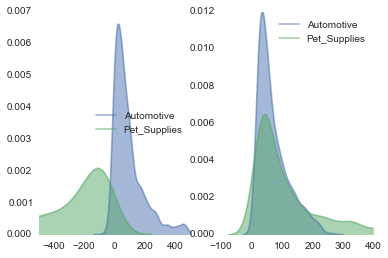

In [171]:
f, axes = plt.subplots(1, 2)
for label in doc_scores.keys():
    sns.kdeplot(np.array(doc_scores[label]), shade=True, alpha=.5, label=label, ax=axes[0])
    sns.kdeplot(np.array(doc_repl_scores[label]), shade=True, alpha=.5, label=label, ax=axes[1])
plt.legend();

axes[0].set_xlim(-500, 500)
axes[1].set_xlim(-100, 400)

# most replacements at the document level are towards non-automotive

(0, 0.3)

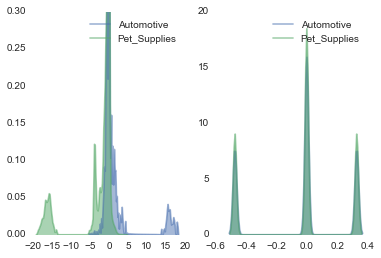

In [130]:
f, axes = plt.subplots(1, 2)
for label in scores.keys():
    sns.kdeplot(np.array(scores[label]), shade=True, alpha=.5, label=label, ax=axes[0])
    sns.kdeplot(np.array(repl_scores[label]), shade=True, alpha=.5, label=label, ax=axes[1])
plt.legend();
axes[0].set_ylim(0, .3)

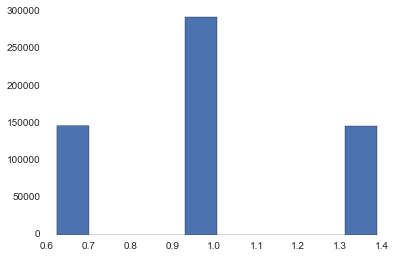

In [138]:
plt.hist(np.exp(repl_scores['Pet_Supplies']));

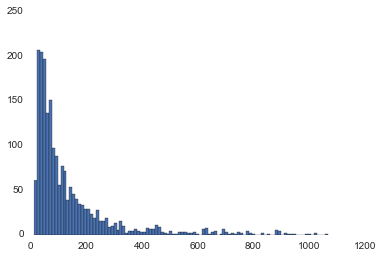

In [135]:
plt.hist([len(doc) for doc in xtr], bins=100);

In [164]:
orig_scores, repl_scores = [], []
for i, (doc, label) in enumerate(zip(xtr, ytr)):
    if i > 600:
        break
    for feat in doc:
        if feat in vocab:
            neigh = v1.get_nearest_neighbours(feat)
            if neigh:
                for repl in neigh:
                    orig_scores.append(orig_lo_automotive[vocab[feat]])
                    repl_scores.append(orig_lo_automotive[vocab[repl[0]]])
#                 print(orig_lo_automotive[vocab[feat]],
#                       '-->', 
#                       [orig_lo_automotive[vocab[repl[0]]] for repl in neigh])
                

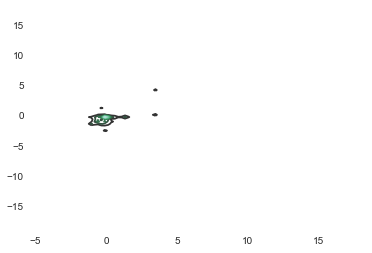

In [165]:
sns.kdeplot(np.array(orig_scores), np.array(repl_scores), shade=False)
# plt.axvline(0);
# plt.axhline(0);